# Figures for GoM trend manuscript

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm

### Load in data for trends

In [3]:
sst_ds = xr.open_dataset('/work5/stb/ERA5/sst.nc', chunks={})
tcc_ds = xr.open_dataset('/work5/stb/ERA5/tcc.nc', chunks={})
mslp_ds = xr.open_dataset('/work5/stb/ERA5/mslp.nc', chunks={})
u10_ds = xr.open_dataset('/work5/stb/ERA5/u10.nc', chunks={})
v10_ds = xr.open_dataset('/work5/stb/ERA5/v10.nc', chunks={})
mask_ds = xr.open_dataset('/work5/stb/ERA5/mask.nc', chunks={})
lcc_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/lcc.nc', chunks={})
glorys = xr.open_dataset('glorys_vars.nc', chunks={})
heat_fluxes = xr.open_dataset('/work/Shanice.Bailey/ERA5/era-heat-fluxes.nc', chunks={})
#hf = xr.open_dataset('/work/Shanice.Bailey/ERA5/heat-fluxes_1959-2021.nc', chunks={})

In [4]:
sst_ds

<xarray.Dataset> Size: 8GB
Dimensions:                  (latitude: 55, longitude: 69, time: 552264)
Coordinates:
  * latitude                 (latitude) float32 220B 31.0 30.75 ... 17.75 17.5
  * longitude                (longitude) float32 276B 262.0 262.2 ... 279.0
  * time                     (time) datetime64[ns] 4MB 1959-01-01 ... 2021-12...
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 8GB dask.array<chunksize=(552264, 55, 69), meta=np.ndarray>

### Process data 
> Time slice
> 
> GoM region slice
> 
> Convert heat fluxes to W m$^{-2}$)

In [5]:
time_slice = dict(time=slice('1993', '2021-06-30'))
gom = dict(longitude=slice(-98, -81), latitude=slice(17.5, 31))

glorys_gom = glorys.sel(**gom).isel(depth=0).drop_vars('depth').sel(**time_slice)
sst = sst_ds.sea_surface_temperature.sel(**time_slice)
tcc = tcc_ds.total_cloud_cover.sel(**time_slice)
mslp = mslp_ds.mean_sea_level_pressure.sel(**time_slice)
u10 = u10_ds['10m_u_component_of_wind'].sel(**time_slice)
v10 = v10_ds['10m_v_component_of_wind'].sel(**time_slice)
mask = mask_ds.land_sea_mask
lcc = lcc_ds.lcc.sel(**time_slice)

sw = heat_fluxes.ssr.sel(**time_slice) / (60*60) #W/m2
lw = heat_fluxes.str.sel(**time_slice) / (60*60) #W/m2
sh = heat_fluxes.sshf.sel(**time_slice) / (60*60) #W/m2
lh = heat_fluxes.slhf.sel(**time_slice) / (60*60) #W/m2

sst_g = glorys_gom.thetao
ssh = glorys_gom.zos
u = glorys_gom.uo
v = glorys_gom.vo
eke = 0.5 * (u**2 + v**2)

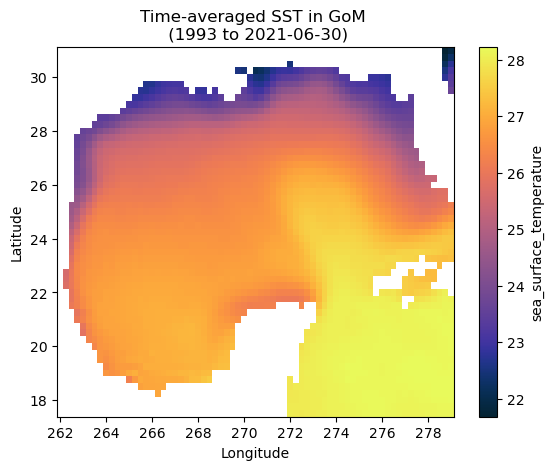

In [26]:
sst.mean('time').plot(cmap=cmocean.cm.thermal)
plt.title('Time-averaged SST in GoM \n (1993 to 2021-06-30)')
plt.xlabel('Longitude')
plt.ylabel('Latitude');

### Calculate linear trend for each data field

In [6]:
#linear regression at every grid cell over time, so that we see trend rate at each grid pt
# Calculate the linear trend at each grid point
def trending(da):
    d = da.groupby('time.year').mean('time').polyfit('year', deg=1, skipna=True, cov=True)

    return d

In [7]:
#era5 vars
trend_sst = trending(sst)
trend_tcc = trending(tcc)
trend_u10 = trending(u10)
trend_v10 = trending(v10)
trend_mslp = trending(mslp)
trend_lcc = trending(lcc)
#heat fluxes
trend_sw = trending(sw)
trend_lw = trending(lw)
trend_sh = trending(sh)
trend_lh = trending(lh)
#glorys vars
trend_sst_g = trending(sst_g)
trend_ssh = trending(ssh)
trend_u = trending(u)
trend_v = trending(v)
trend_eke = trending(eke)

In [8]:
trend_sst

<xarray.Dataset> Size: 213kB
Dimensions:               (degree: 2, latitude: 55, longitude: 69, cov_i: 2,
                           cov_j: 2)
Coordinates:
  * degree                (degree) int64 16B 1 0
  * latitude              (latitude) float32 220B 31.0 30.75 30.5 ... 17.75 17.5
  * longitude             (longitude) float32 276B 262.0 262.2 ... 278.8 279.0
Dimensions without coordinates: cov_i, cov_j
Data variables:
    polyfit_coefficients  (degree, latitude, longitude) float64 61kB dask.array<chunksize=(2, 55, 69), meta=np.ndarray>
    polyfit_residuals     (latitude, longitude) float64 30kB dask.array<chunksize=(55, 69), meta=np.ndarray>
    polyfit_covariance    (cov_i, cov_j, latitude, longitude) float64 121kB dask.array<chunksize=(2, 2, 55, 69), meta=np.ndarray>

## Trends (spatial maps)

In [34]:
def plot_trend(da, title, cbar_label, v_min, v_max, cmap_choice, diverge=True):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))
    
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    if diverge==True:
        d = da.polyfit_coefficients[0]
        norm = TwoSlopeNorm(vmin=v_min, vcenter=0, vmax=v_max)
        im = ax.pcolormesh(d.longitude, d.latitude, d, transform=ccrs.PlateCarree(), 
                           norm=norm, cmap=cmap_choice)
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        
        plt.title(f'{title}', fontsize=26);
    else:
        d = da.polyfit_coefficients[0]
        im = ax.pcolormesh(d.longitude, d.latitude, d, transform=ccrs.PlateCarree(), 
                           vmin=v_min, vmax=v_max, cmap=cmap_choice)#norm=LogNorm(),
        cb = fig.colorbar(im, ax=ax, shrink=0.4)
        cb.set_label(fr"{cbar_label}", labelpad=12, fontsize=20)
        
        g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        g1.xlabels_top = False
        g1.ylabels_right = False
        
        plt.title(f'{title}', fontsize=26);

In [35]:
print('Max: ', trend_sst.polyfit_coefficients[0].max().values, '˚C/yr', 
      '\nMin: ', trend_sst.polyfit_coefficients[0].min().values, '˚C/yr')

Max:  0.04232917184312922 ˚C/yr 
Min:  -0.022699355139520358 ˚C/yr


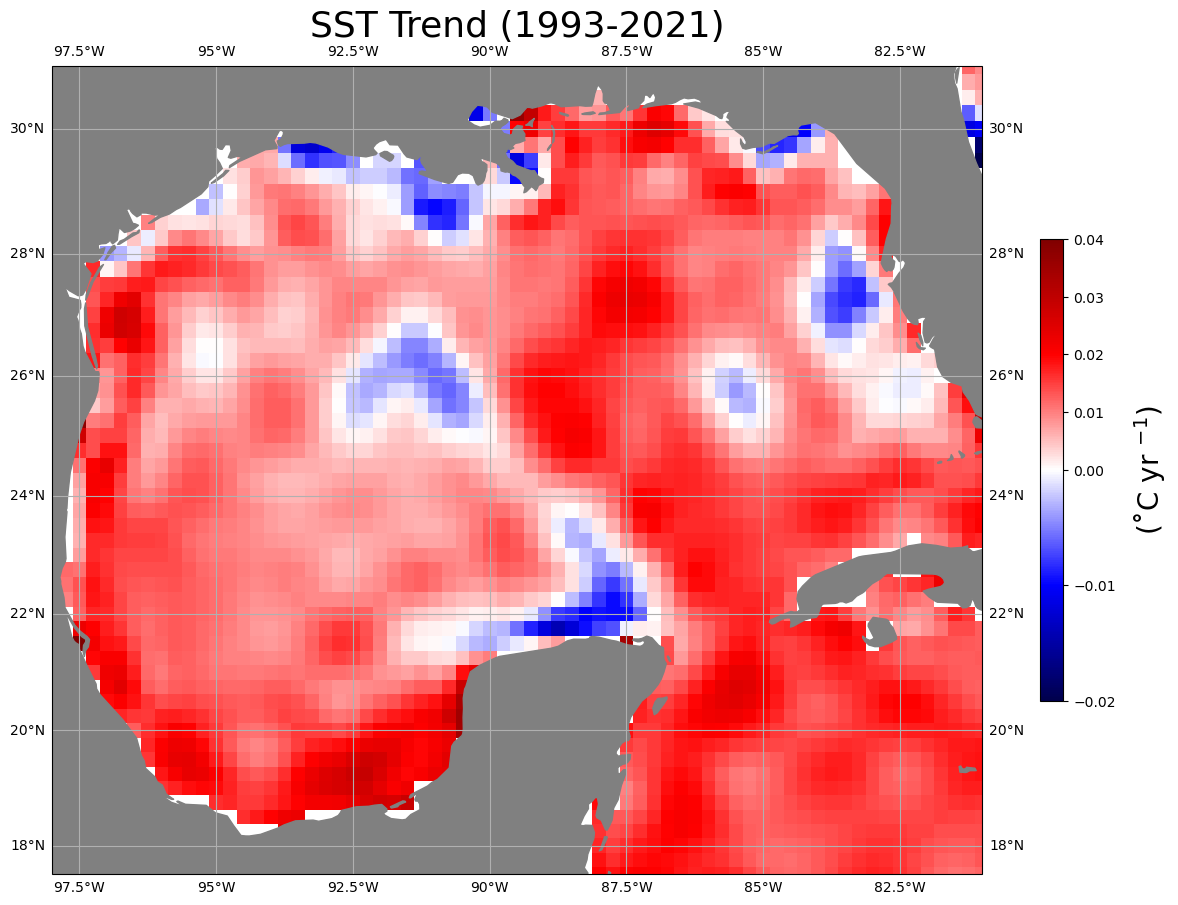

In [51]:
plot_trend(trend_sst, 'SST Trend (1993-2021)', '(˚C yr $^{-1}$)', -0.02, 0.04, cmap_choice='seismic')

In [17]:
print('Max: ', trend_tcc.polyfit_coefficients[0].max().values, 'frac/yr', 
      '\nMin: ', trend_tcc.polyfit_coefficients[0].min().values, 'frac/yr')

Max:  0.003308315802677439 frac/yr 
Min:  -0.0012246471907704866 frac/yr


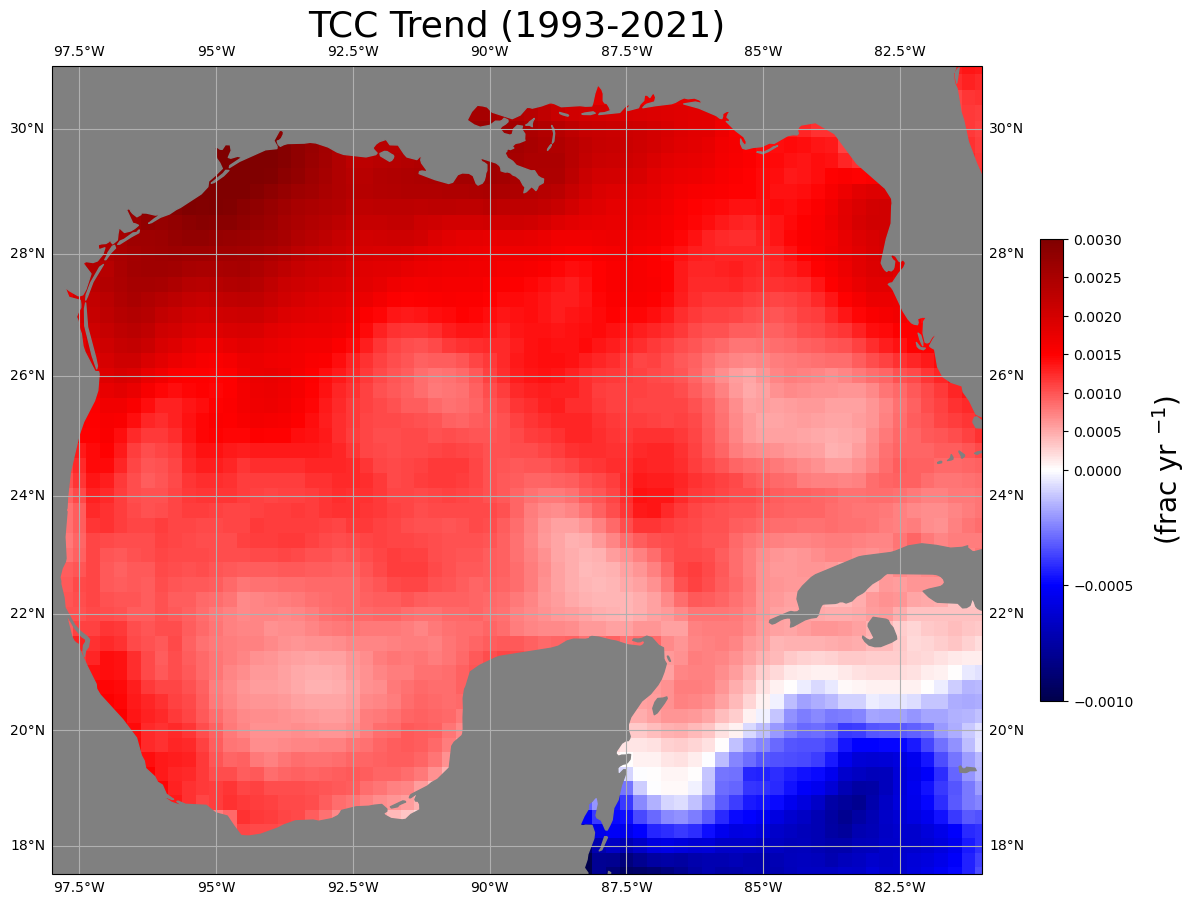

In [50]:
plot_trend(trend_tcc, 'TCC Trend (1993-2021)', '(frac yr $^{-1}$)', -0.001, 0.003, cmap_choice='seismic')

In [20]:
print('Max: ', trend_lcc.polyfit_coefficients[0].max().values, 'frac/yr', 
      '\nMin: ', trend_lcc.polyfit_coefficients[0].min().values, 'frac/yr')

Max:  0.0025543250321752482 frac/yr 
Min:  -0.0019290250027619756 frac/yr


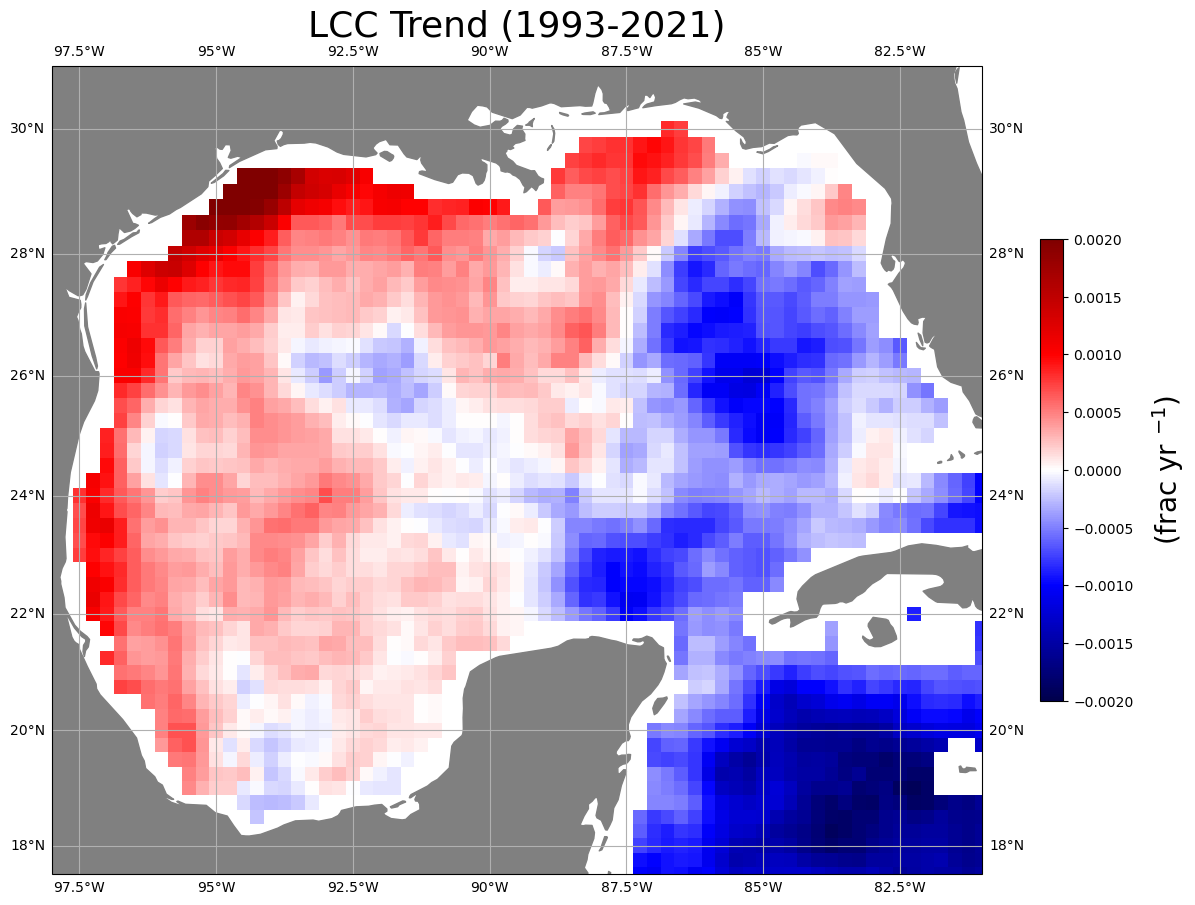

In [22]:
plot_trend(trend_lcc, 'LCC Trend (1993-2021)', '(frac yr $^{-1}$)', -0.002, 0.002, cmap_choice='seismic')

In [25]:
print('Max: ', trend_u10.polyfit_coefficients[0].max().values, 'm/s/yr', 
      '\nMin: ', trend_u10.polyfit_coefficients[0].min().values, 'm/s/yr')

Max:  0.01145737958071838 m/s/yr 
Min:  -0.021471307665256012 m/s/yr


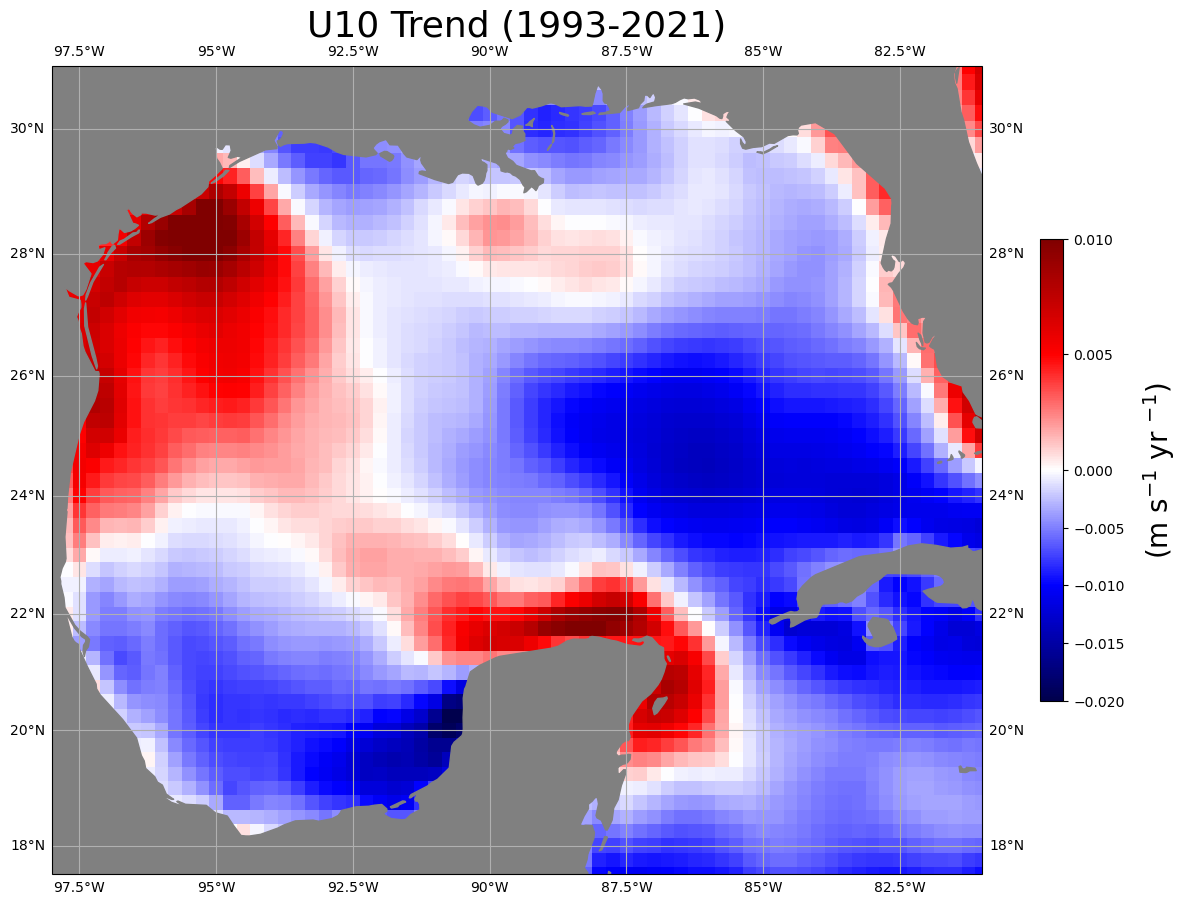

In [49]:
plot_trend(trend_u10, 'U10 Trend (1993-2021)', '(m s$^{-1}$ yr $^{-1}$)', -0.02, 0.01, cmap_choice='seismic')

In [27]:
print('Max: ', trend_v10.polyfit_coefficients[0].max().values, 'm/s/yr', 
      '\nMin: ', trend_v10.polyfit_coefficients[0].min().values, 'm/s/yr')

Max:  0.017991427923070822 m/s/yr 
Min:  -0.007464926631139184 m/s/yr


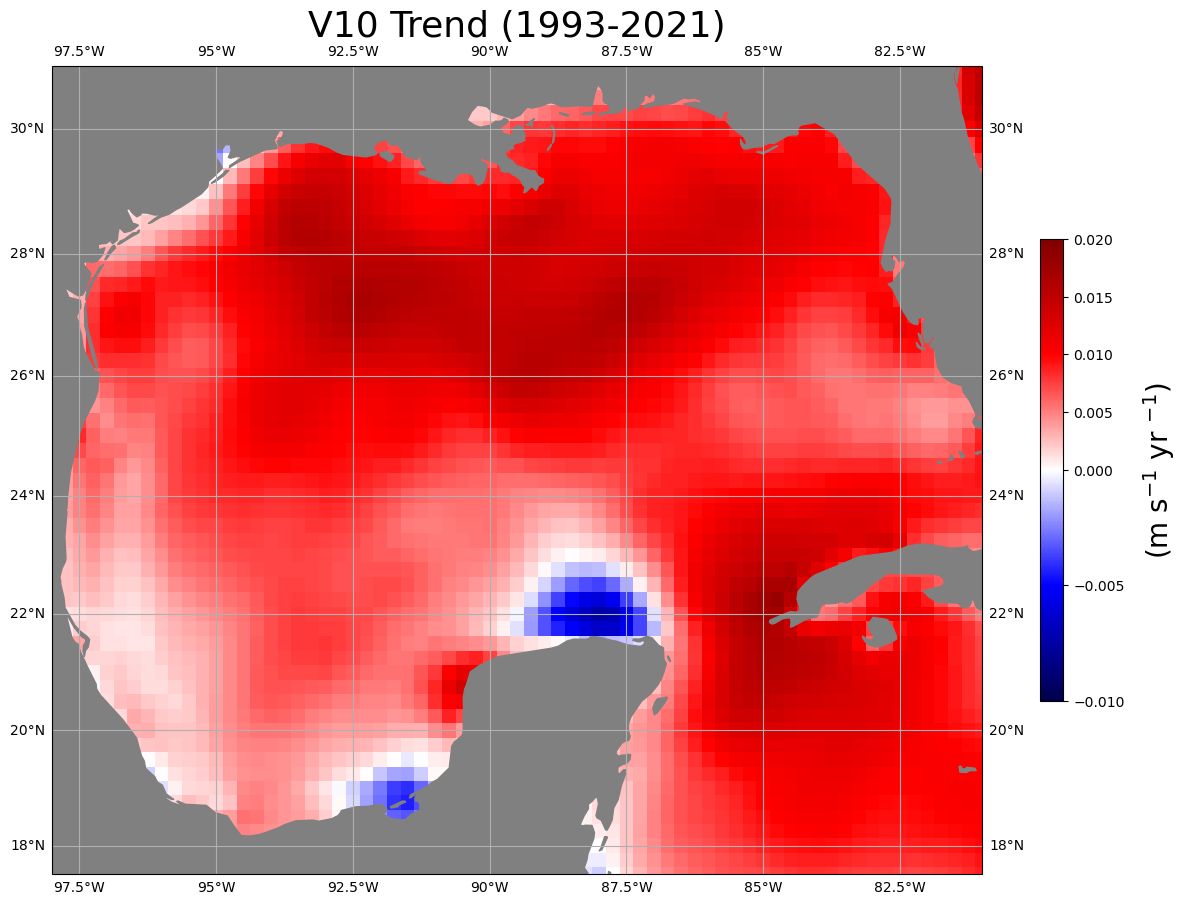

In [47]:
plot_trend(trend_v10, 'V10 Trend (1993-2021)', '(m s$^{-1}$ yr $^{-1}$)', -0.01, 0.02, cmap_choice='seismic')

In [30]:
print('Max: ', trend_mslp.polyfit_coefficients[0].max().values, 'Pa/yr', 
      '\nMin: ', trend_mslp.polyfit_coefficients[0].min().values, 'Pa/yr')

Max:  2.5969866071434935 Pa/yr 
Min:  0.9614262623144919 Pa/yr


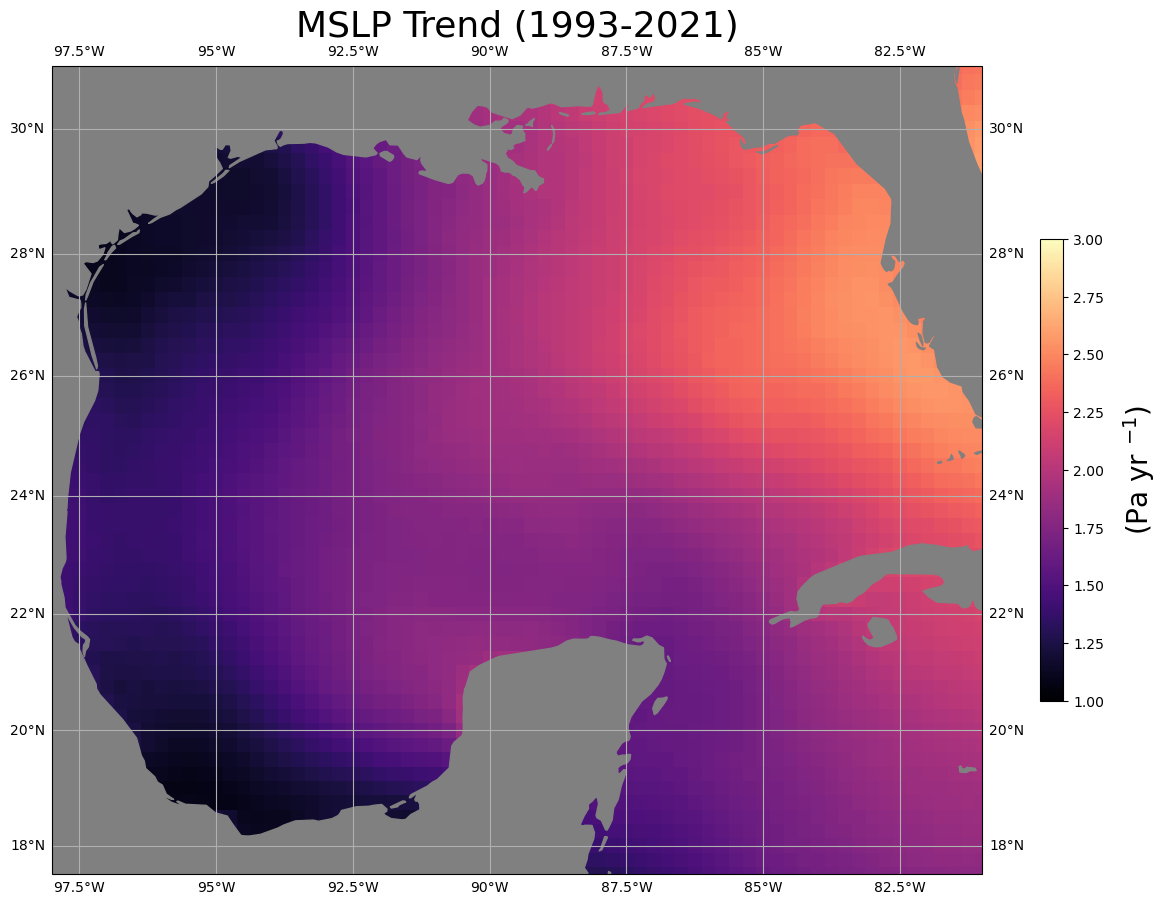

In [38]:
plot_trend(trend_mslp, 'MSLP Trend (1993-2021)', '(Pa yr $^{-1}$)', 1,3, diverge=False, cmap_choice='magma')

In [39]:
print('Max: ', trend_sw.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_sw.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.21477920597152494 W/m2/yr 
Min:  -0.12834750811221804 W/m2/yr


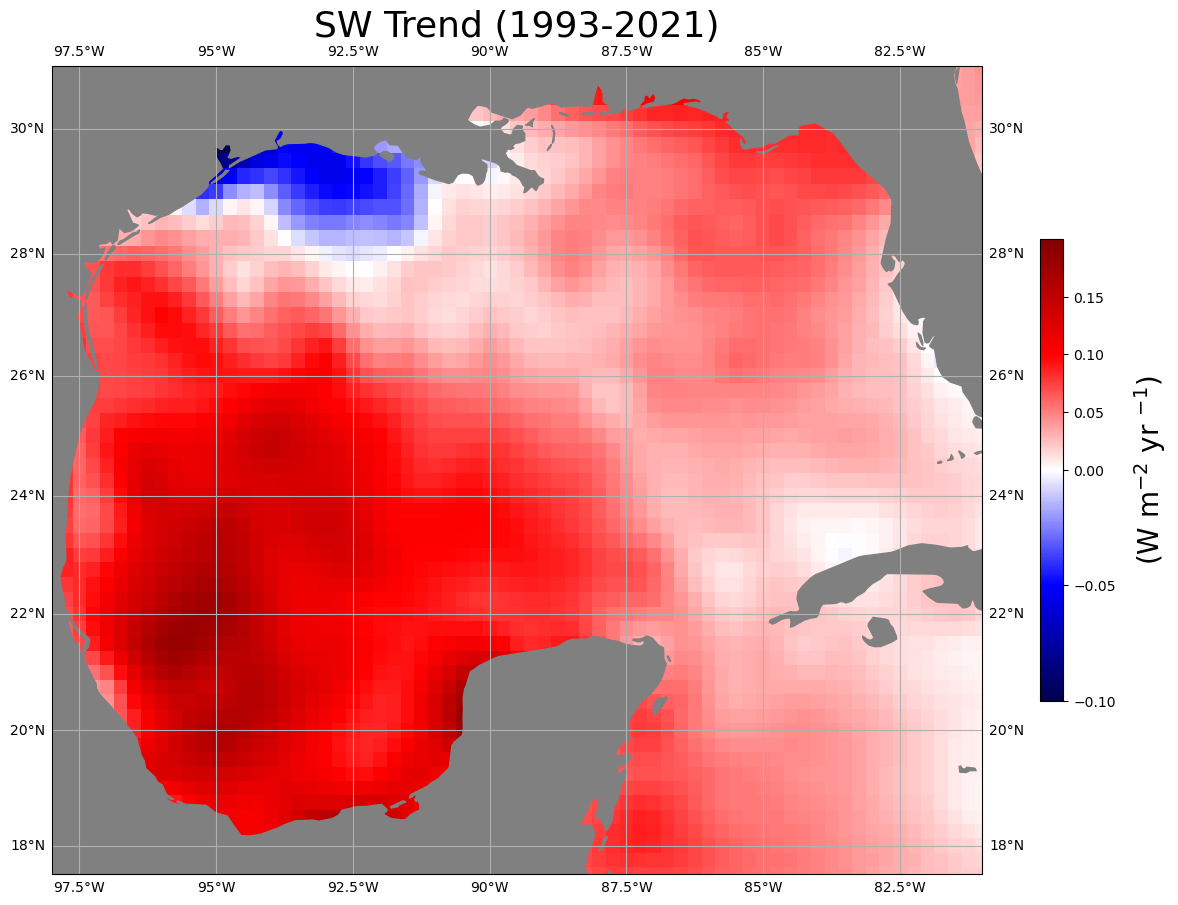

In [46]:
plot_trend(trend_sw, 'SW Trend (1993-2021)', '(W m$^{-2}$ yr $^{-1}$)', -0.1, 0.2, cmap_choice='seismic')

In [41]:
print('Max: ', trend_lw.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_lw.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.2851566449633192 W/m2/yr 
Min:  -0.07942398785588661 W/m2/yr


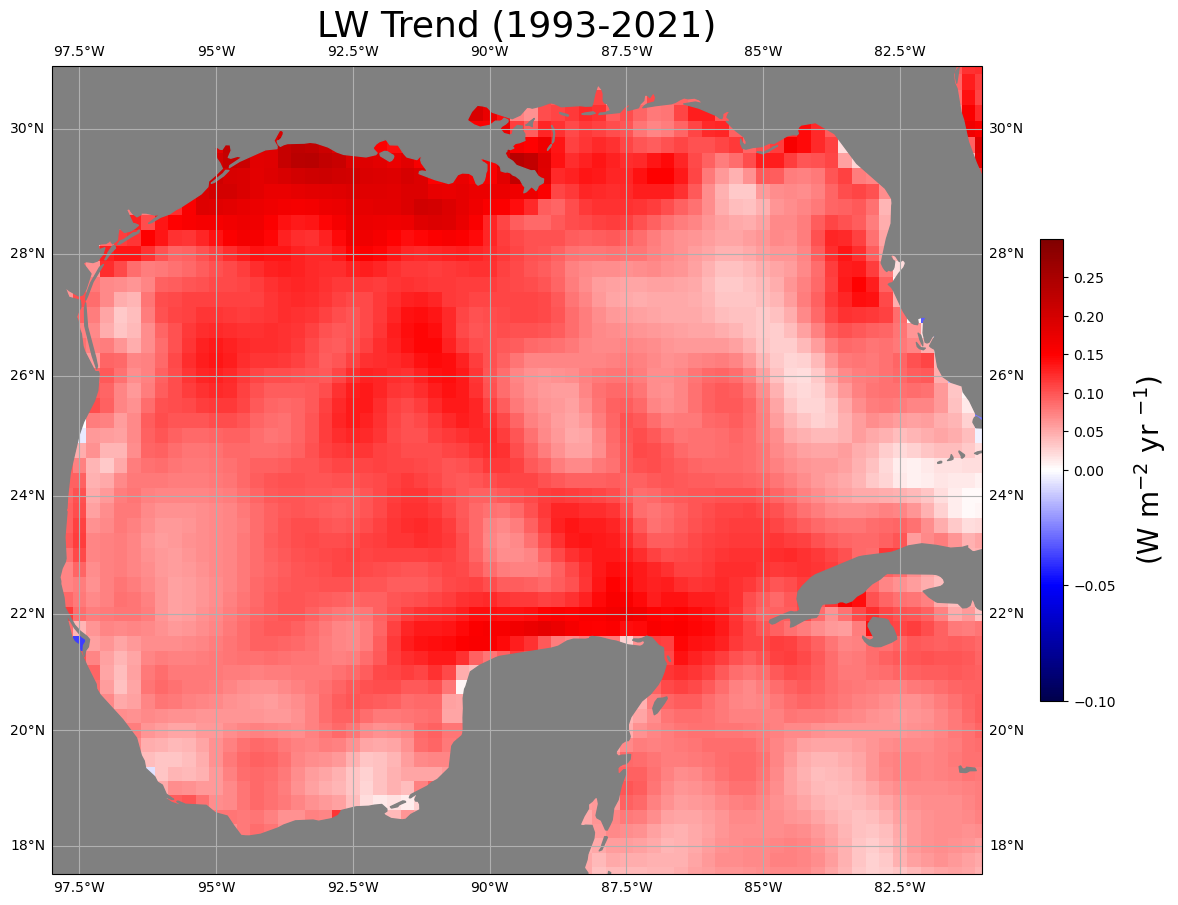

In [45]:
plot_trend(trend_lw, 'LW Trend (1993-2021)', '(W m$^{-2}$ yr $^{-1}$)', -0.1, 0.3, cmap_choice='seismic')

In [52]:
print('Max: ', trend_lh.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_lh.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  1.0175485311513646 W/m2/yr 
Min:  -1.0396743852021677 W/m2/yr


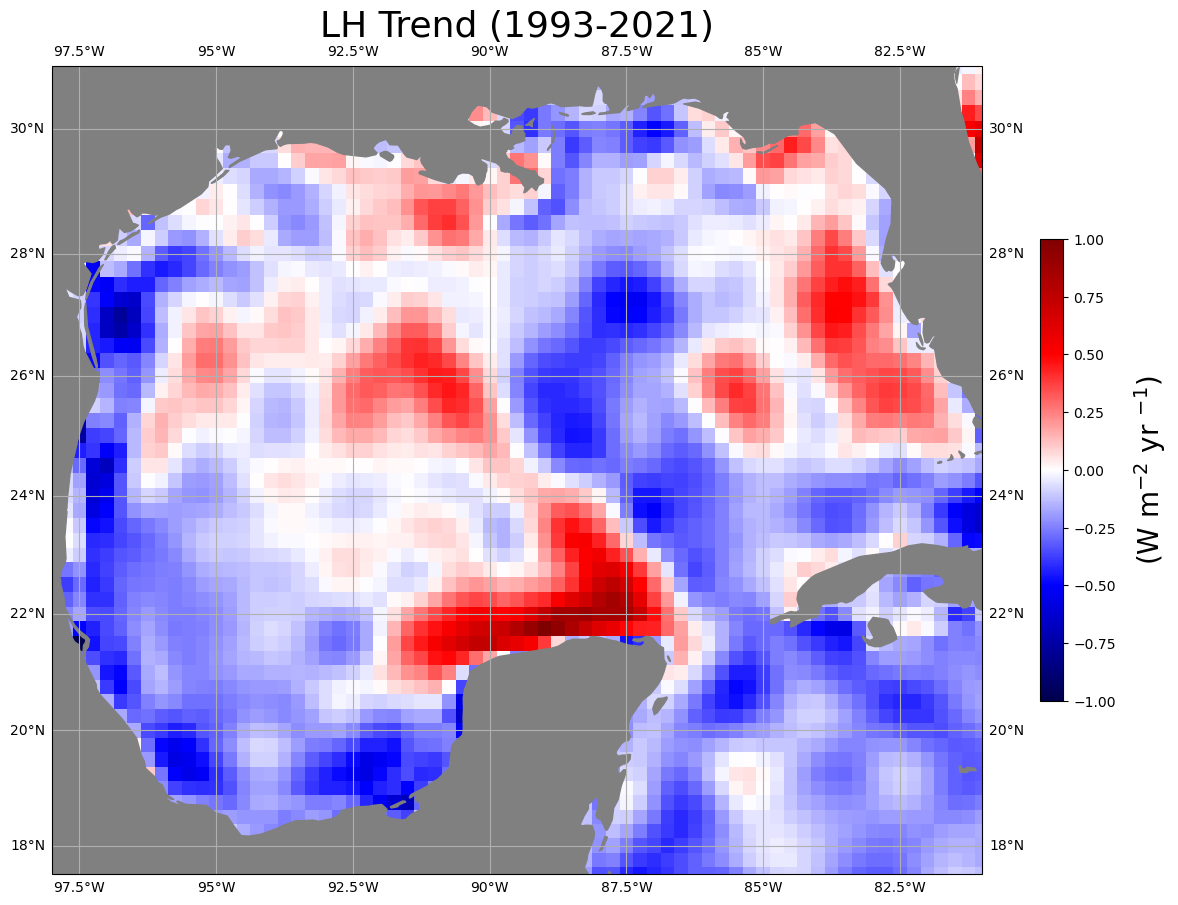

In [53]:
plot_trend(trend_lh, 'LH Trend (1993-2021)', '(W m$^{-2}$ yr $^{-1}$)', -1, 1, cmap_choice='seismic')

In [54]:
print('Max: ', trend_sh.polyfit_coefficients[0].max().values, 'W/m2/yr', 
      '\nMin: ', trend_sh.polyfit_coefficients[0].min().values, 'W/m2/yr')

Max:  0.7670891259812079 W/m2/yr 
Min:  -0.44202784551826113 W/m2/yr


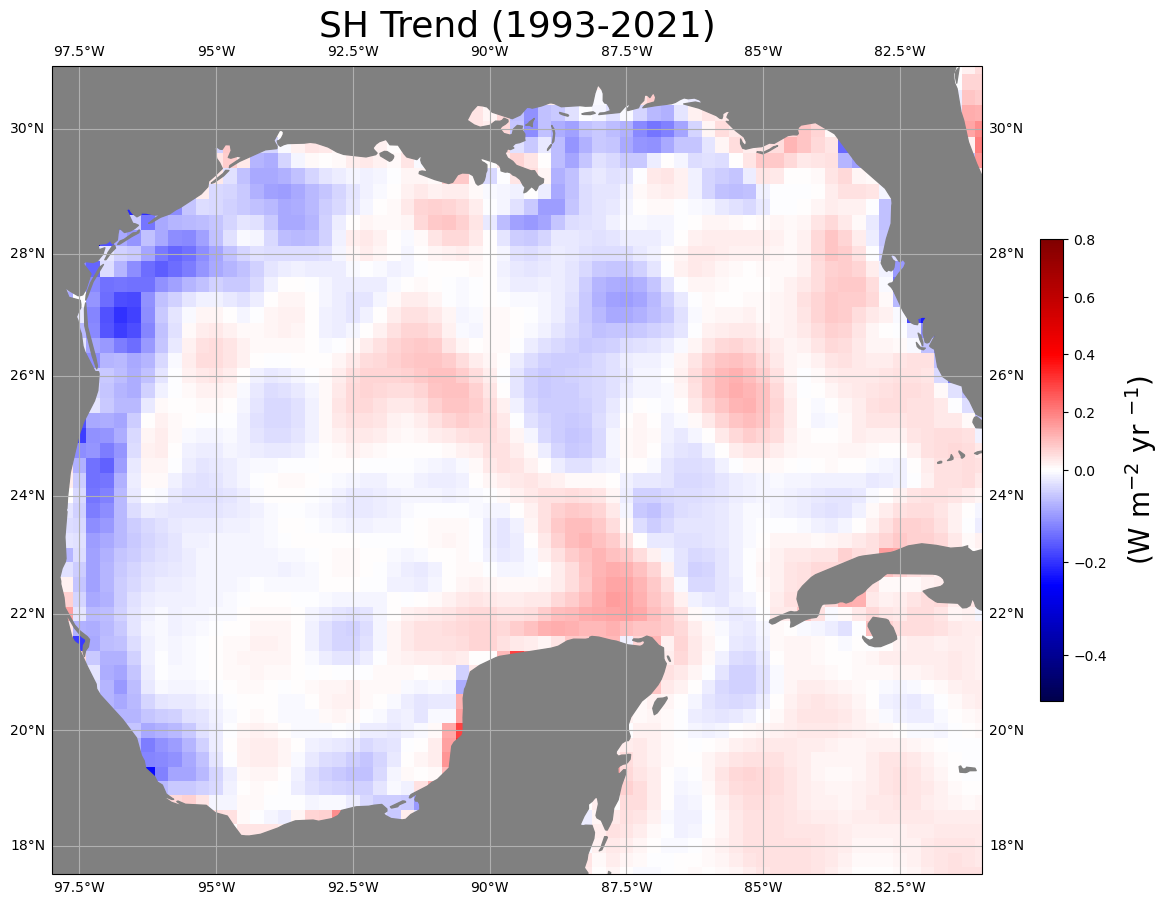

In [55]:
plot_trend(trend_sh, 'SH Trend (1993-2021)', '(W m$^{-2}$ yr $^{-1}$)', -0.5, 0.8, cmap_choice='seismic')

In [56]:
print('Max: ', trend_sst_g.polyfit_coefficients[0].max().values, '˚C/yr', 
      '\nMin: ', trend_sst_g.polyfit_coefficients[0].min().values, '˚C/yr')

Max:  0.029032845992137648 ˚C/yr 
Min:  -0.0334678885237912 ˚C/yr


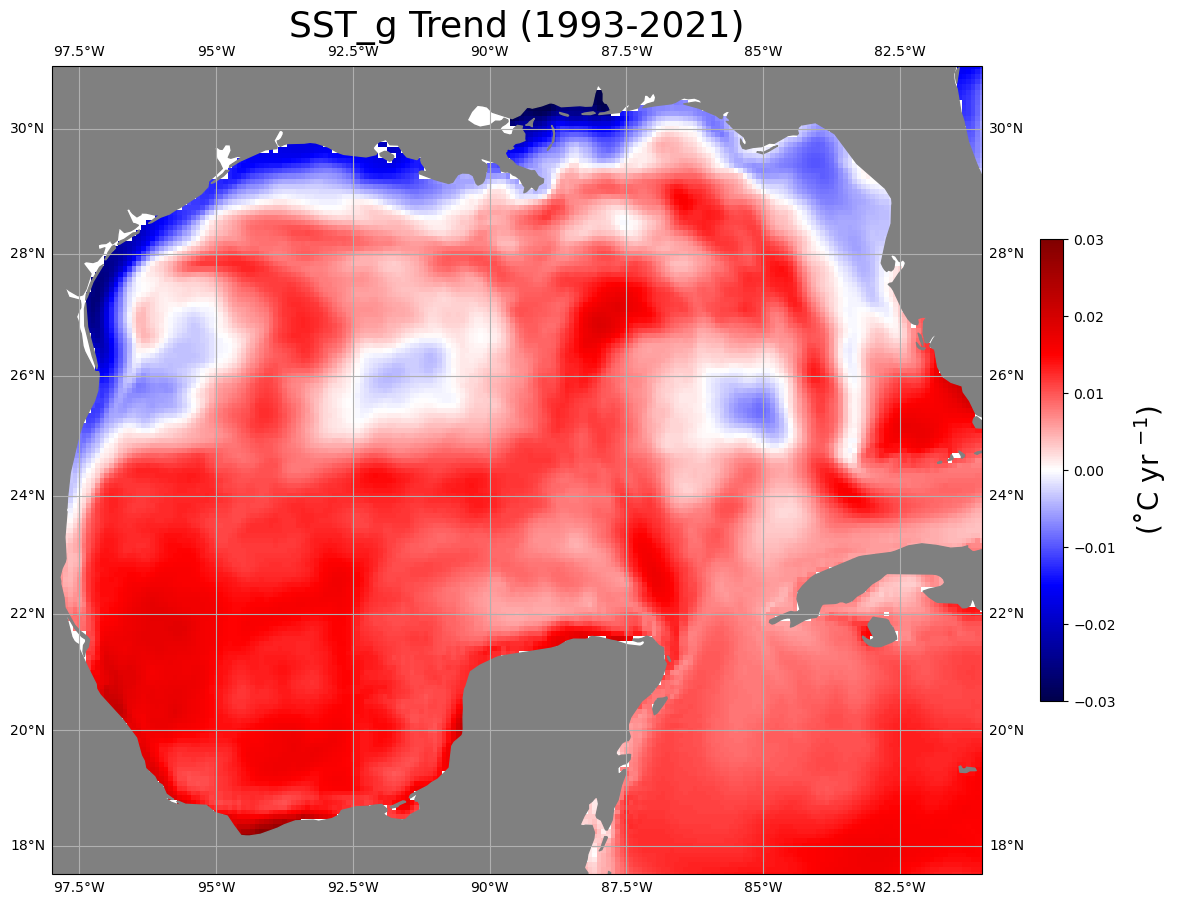

In [57]:
plot_trend(trend_sst_g, 'SST_g Trend (1993-2021)', '(˚C yr $^{-1}$)', -0.03, 0.03, cmap_choice='seismic')

In [59]:
print('Max: ', trend_ssh.polyfit_coefficients[0].max().values, 'm/yr', 
      '\nMin: ', trend_ssh.polyfit_coefficients[0].min().values, 'm/yr')

Max:  0.006235263610535404 m/yr 
Min:  -0.0011776598752006326 m/yr


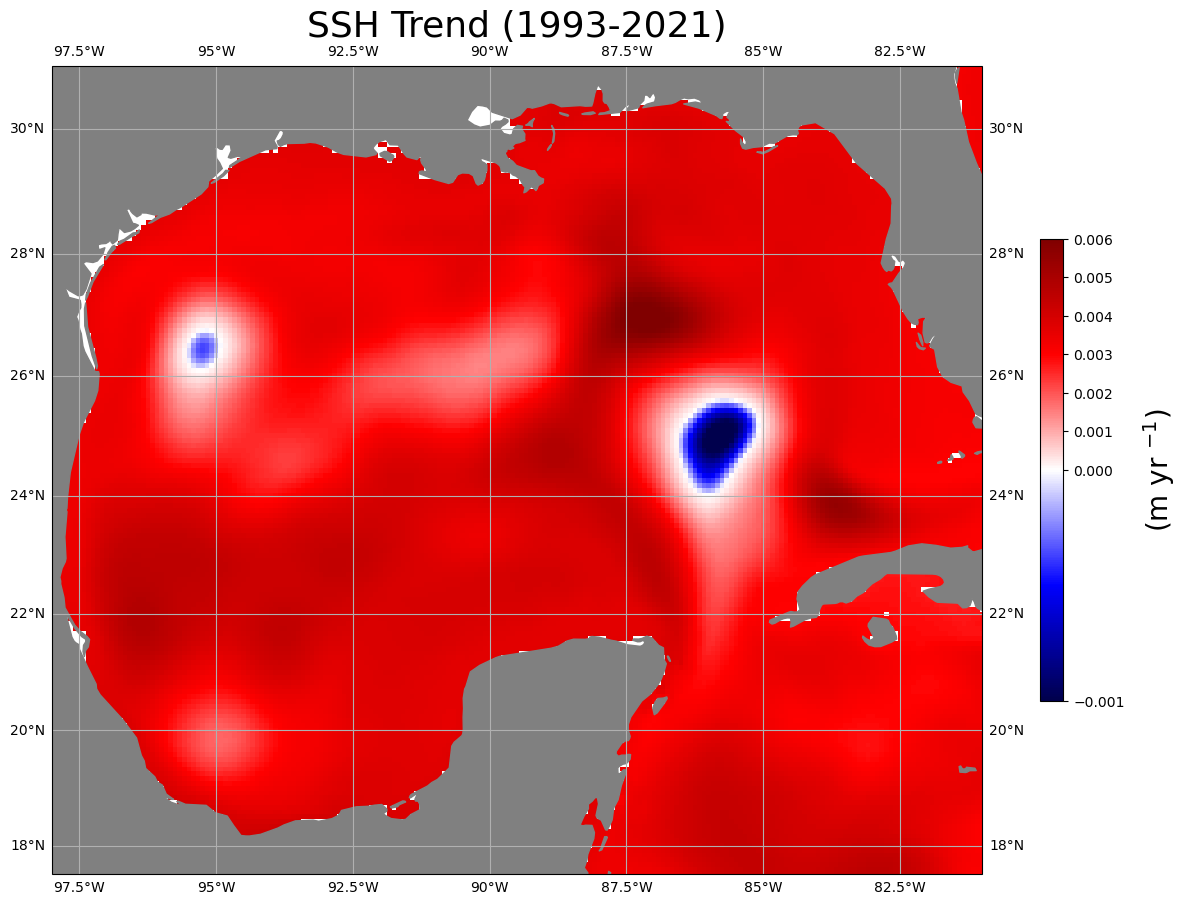

In [60]:
plot_trend(trend_ssh, 'SSH Trend (1993-2021)', '(m yr $^{-1}$)', -0.001, 0.006, cmap_choice='seismic')

In [62]:
print('Max: ', trend_u.polyfit_coefficients[0].max().values, 'm/s/yr', 
      '\nMin: ', trend_u.polyfit_coefficients[0].min().values, 'm/s/yr')

Max:  0.005944803935781214 m/s/yr 
Min:  -0.006900215880927309 m/s/yr


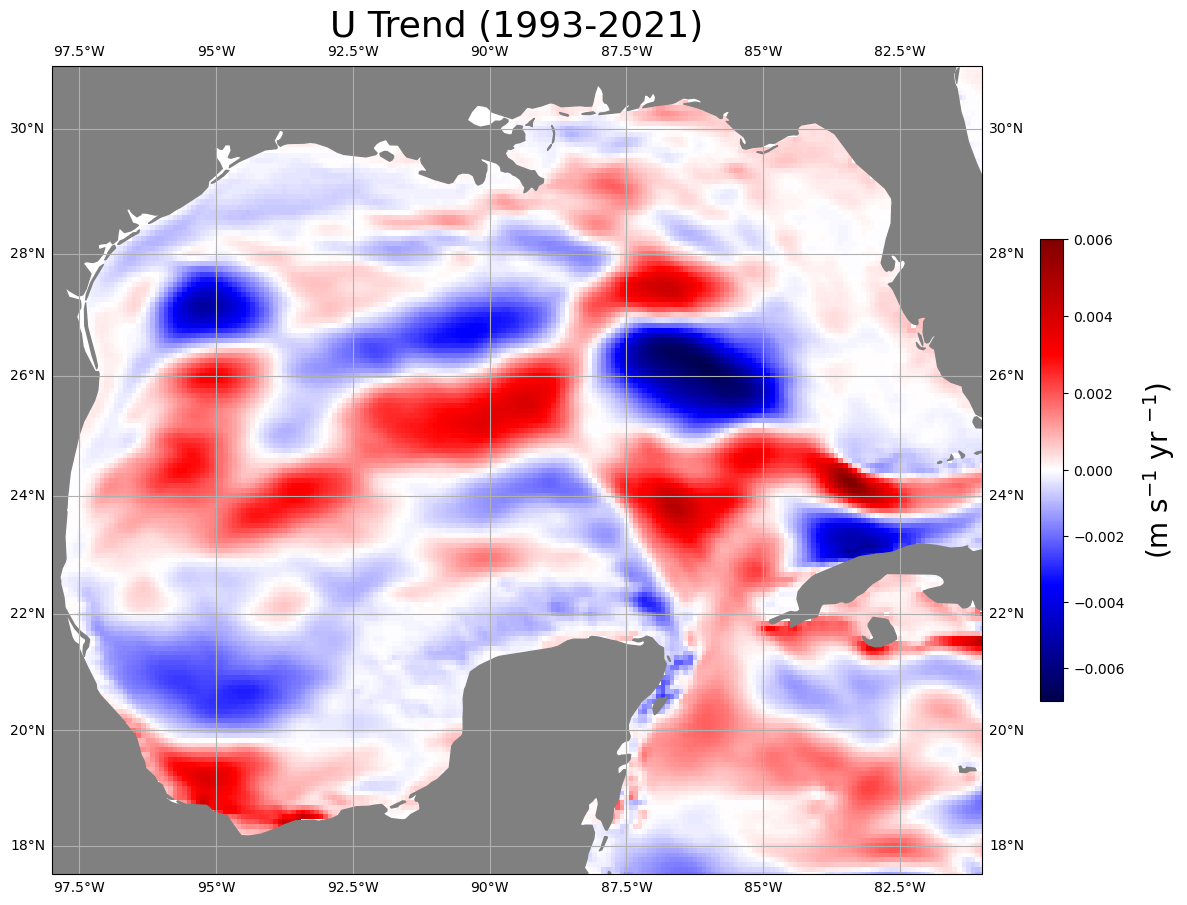

In [63]:
plot_trend(trend_u, 'U Trend (1993-2021)', '(m s$^{-1}$ yr $^{-1}$)', -0.007, 0.006, cmap_choice='seismic')

In [64]:
print('Max: ', trend_v.polyfit_coefficients[0].max().values, 'm/s/yr', 
      '\nMin: ', trend_v.polyfit_coefficients[0].min().values, 'm/s/yr')

Max:  0.007324029156864233 m/s/yr 
Min:  -0.0070908477964109285 m/s/yr


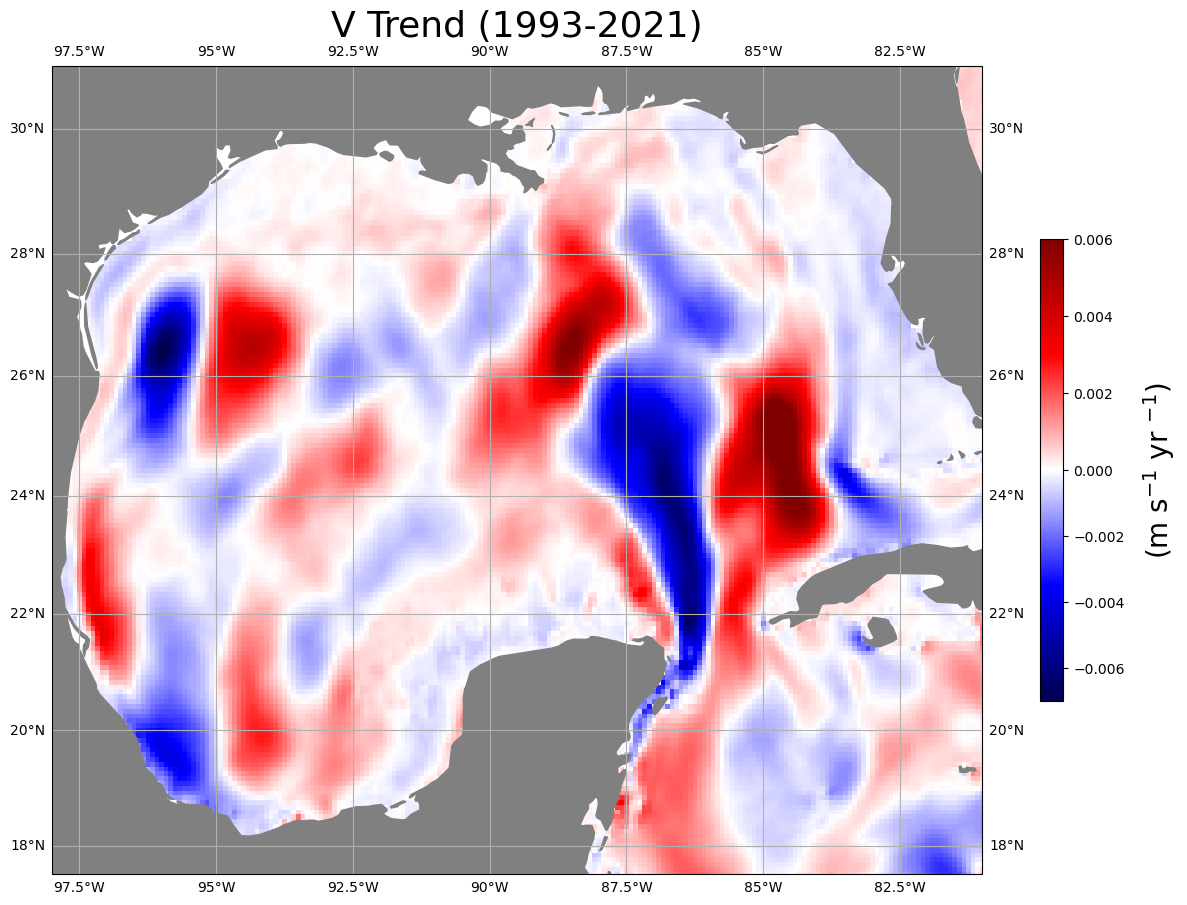

In [66]:
plot_trend(trend_v, 'V Trend (1993-2021)', '(m s$^{-1}$ yr $^{-1}$)', -0.007, 0.006, cmap_choice='seismic')

In [62]:
print('Max: ', trend_eke.polyfit_coefficients[0].max().values, 'm2/s2/yr', 
      '\nMin: ', trend_eke.polyfit_coefficients[0].min().values, 'm2/s2/yr')

Max:  0.005944803935781214 m/s/yr 
Min:  -0.006900215880927309 m/s/yr


In [ ]:
plot_trend(trend_u, 'U Trend (1993-2021)', '(m s$^{-1}$ yr $^{-1}$)', -0.007, 0.006, cmap_choice='seismic')

## Trends (basin-average)

## EOF composites

### Load in data for EOFs